## Further Ideas

### Change the Loss Function to Wasserstein Distance
[Wasserstein GANs (WGAN)](https://arxiv.org/pdf/1701.07875.pdf) are an alternative to *classical* GANs. They use a different loss function and prooved to be more stable to hyperparameter selection. While the paper offers a good theoretical introduction and reasoning why they perform better in many cases, [this article](https://wiseodd.github.io/techblog/2017/02/04/wasserstein-gan/) provides a good practical introduction

In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

tf.reset_default_graph()

In [2]:
from tensorflow.keras.datasets.mnist import load_data
(train_X, train_y),(test_X, test_y) = load_data()

train_X = train_X/255.0
train_y = train_y/255.0

test_X = test_X/255.0
test_y = test_y/255.0


train = np.append(train_X, test_X, axis=0) #Use both Train and Testset for GAN

In [ ]:
"""WGAN"""
def discriminator(X, reuse_vars=None):
    with tf.variable_scope('dis', reuse=reuse_vars):
        
        conv1 = tf.layers.conv2d(inputs=X, filters=32, kernel_size=[5,5], padding="same", activation=tf.nn.relu, name="conv1")

        pool1 = tf.layers.average_pooling2d(inputs=conv1, pool_size=[2,2], strides=2, name="pool1")

        conv2 = tf.layers.conv2d(inputs=pool1, filters=64, kernel_size=[5,5], padding="same", activation=tf.nn.relu, name="conv2")

        pool2 = tf.layers.average_pooling2d(inputs=conv2, pool_size=[2,2], strides=2, name="pool2")

        flat_layer = tf.reshape(pool2, [-1, 7 * 7 * 64], name="flatten")

        # Dense layer
        dense = tf.layers.dense(inputs=flat_layer, units=1024, activation=tf.nn.relu, name="dense")

        # Logits layer
        logits = tf.layers.dense(inputs=dense, units=1, name="dense2")
        
        #output = tf.sigmoid(logits, name="sigmoid")
        
        return logits

In [4]:
def gen(noise, reuse_vars=None):
    with tf.variable_scope("gen", reuse=reuse_vars):
        
        # First DenseLayer
        dense = tf.layers.dense(inputs=noise, units=3136, activation=tf.nn.relu, name="dense")
        
        #Reshape
        reshape = tf.reshape(dense, [-1, 56, 56, 1], name="reshape")
        
        #1 Conv2d
        conv1 = tf.layers.conv2d(inputs=reshape, filters=50, kernel_size=[3,3], strides=2, padding="same", activation=tf.nn.relu, name="conv1")
        
        #BatchNormalization
        conv1_norm = tf.layers.batch_normalization(conv1, name="batch_norm1")
        
        #Upsample
        conv1_upsample = tf.image.resize_images(conv1_norm, (56,56))
        
        #2 Conv2d
        conv2 = tf.layers.conv2d(inputs=conv1_upsample, filters=25, kernel_size=[3,3], strides=2, padding="same", activation=tf.nn.relu, name="conv2")
        
        #BatchNormalization
        conv2_norm = tf.layers.batch_normalization(conv2, name="batch_norm2")
        
        #Upsample
        conv2_upsample = tf.image.resize_images(conv2_norm, (56,56))
        
        #2 Conv2d
        logits = tf.layers.conv2d(inputs=conv2_upsample, filters=1, kernel_size=[3,3], strides=2, padding="same", name="conv3")
        output = tf.nn.sigmoid(logits, name="sigmoid")
        
        return output


In [5]:
with tf.name_scope('input'):
    real_images = tf.placeholder(tf.float32, shape=[None, 28,28,1], name="ImagePlaceholder")
    z = tf.placeholder(tf.float32, shape=[None, 100], name = "NoisePlaceholder")

In [ ]:
"""WGAN"""
Gz = gen(z)
D_logits_real = discriminator(real_images)
D_logits_fake = discriminator(Gz, reuse_vars=True)

In [ ]:
"""WGAN"""
D_loss = tf.reduce_mean(D_real) - tf.reduce_mean(D_fake)
G_loss = -tf.reduce_mean(D_fake)

In [ ]:
"""WGAN"""
# theta_D is list of D's params
clip_D = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in theta_D]

In [10]:
D_learning_rate = 0.00005
G_learning_rate = 0.0001

In [ ]:
"""WGAN"""
theta_D = tf.trainable_variables(scope='dis')
theta_G = tf.trainable_variables(scope='gen')

In [12]:
D_trainer = tf.train.RMSPropOptimizer(D_learning_rate, name="RMSPropOptimizer_Discriminator").minimize(D_loss, var_list=d_vars, name="minimize_D_loss")
G_trainer = tf.train.RMSPropOptimizer(G_learning_rate, name="RMSPropOptimizer_Generator").minimize(G_loss, var_list=g_vars, name="minimize_G_loss")



In [ ]:
"""Train D more"""
for it in range(1000000):
    for _ in range(5):
        X_mb, _ = mnist.train.next_batch(mb_size)

        _, D_loss_curr, _ = sess.run(
            [D_solver, D_loss, clip_D],
            feed_dict={X: X_mb, z: sample_z(mb_size, z_dim)}
        )

    _, G_loss_curr = sess.run(
        [G_solver, G_loss],
        feed_dict={z: sample_z(mb_size, z_dim)}
    )

In [13]:
tf.summary.scalar("Dx_Loss", D_real_loss)
tf.summary.scalar("Dg_Loss", D_fake_loss)
tf.summary.scalar("D_loss", D_loss)
tf.summary.scalar("G_loss", G_loss)
tf.summary.image("Generated_Images", Gz, max_outputs=5)

<tf.Tensor 'Generated_Images:0' shape=() dtype=string>

In [14]:
import datetime

now = datetime.datetime.now()

In [15]:
BATCH_SIZE = 100
BUFFER_SIZE = 140000
EPOCHS = 500000 

In [16]:
samples = []
real = []

In [17]:
from tqdm import tqdm

train = train.reshape(train.shape[0], 28, 28, 1).astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices(train).repeat().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
iterator = train_dataset.make_one_shot_iterator()
nextbatch = iterator.get_next()
init = tf.global_variables_initializer()

In [19]:
#with tf.Session(config=config) as sess:
with tf.Session() as sess:
    
    sess.run(init)
    writer = tf.summary.FileWriter('./tensorboard/{0}_TrainableVariables_500K-Epochs'.format(now.strftime("%Y_%m_%d-%H-%M")), sess.graph)
    
    for pretrain in tqdm(range(20)):
        batch_images = sess.run(nextbatch)

        #batch = mnist.train.next_batch(BATCH_SIZE)
        #batch_images = batch[0].reshape((BATCH_SIZE, 28,28))
        #batch_images = np.expand_dims(batch_images, axis=-1)

        #print(batch_images.shape)


        #batch_images = batch_images * 2 - 1  # Use for TANH to remap between -1 and 1

        batch_z = np.random.normal(0,1,size=(BATCH_SIZE,100))
        _ = sess.run(D_trainer, feed_dict={real_images:batch_images, z:batch_z})
    
    
    for epoch in tqdm(range(EPOCHS)):
        
        #num_batches = len(train) // BATCH_SIZE
        
        #for batch in range(num_batches):
            
        batch_images = sess.run(nextbatch)

        #batch = mnist.train.next_batch(BATCH_SIZE)
        #batch_images = batch[0].reshape((BATCH_SIZE, 28,28))
        #batch_images = np.expand_dims(batch_images, axis=-1)

        #print(batch_images.shape)


        #batch_images = batch_images * 2 - 1  # Use for TANH to remap between -1 and 1


        batch_z = np.random.normal(0,1,size=(BATCH_SIZE,100))
        D_summary, _, discrloss, discr_r_loss, discr_f_loss = sess.run([merged, D_trainer, D_loss, D_real_loss, D_fake_loss], feed_dict={real_images:batch_images, z:batch_z})
        genloss, _ = sess.run([G_loss, G_trainer], feed_dict={z:batch_z})

        if (epoch % 10 == 0):{
            # SUMMARIES
            writer.add_summary(D_summary, epoch)
            #print(genloss)
        }

        #print ("ON EPOCH {}".format(epoch))
        
        if (epoch%5000 == 0):
            
            sample_z = np.random.normal(0,1,size=(1,100))
            gen_sample = sess.run(gen(z, reuse_vars=True), feed_dict={z: sample_z})
            samples.append(gen_sample)
            plt.imshow(gen_sample.reshape(28,28), cmap="gray")
            plt.show()
        


  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

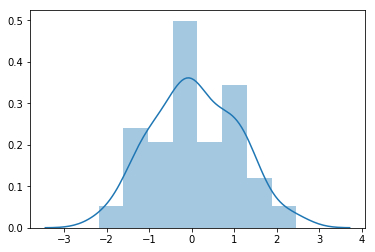

In [36]:
sns.distplot(np.random.normal(0,1,100))